In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import random

%matplotlib inline

In [3]:
import copy
import pickle
import time
from pprint import pprint

In [4]:
from typing import List, Tuple, Union, Dict

In [5]:
from loguru import logger

In [6]:
import xgboost
xgboost.__version__

'1.7.2'

In [7]:
from tqdm import tqdm

In [8]:
from bps_numerical.misc.plotutils import plot_feature_scores

# Data Loader

Load data. We have 2 types of CSV files:
- csv with gene expression data samples
- csv with metadata information relating to target attributes for each sample

The **expanded** datasets are the **gaussian-noise-upsampled** datasets which are used to train a GAN model.
The GAN model is further used to generate **fake** samples.

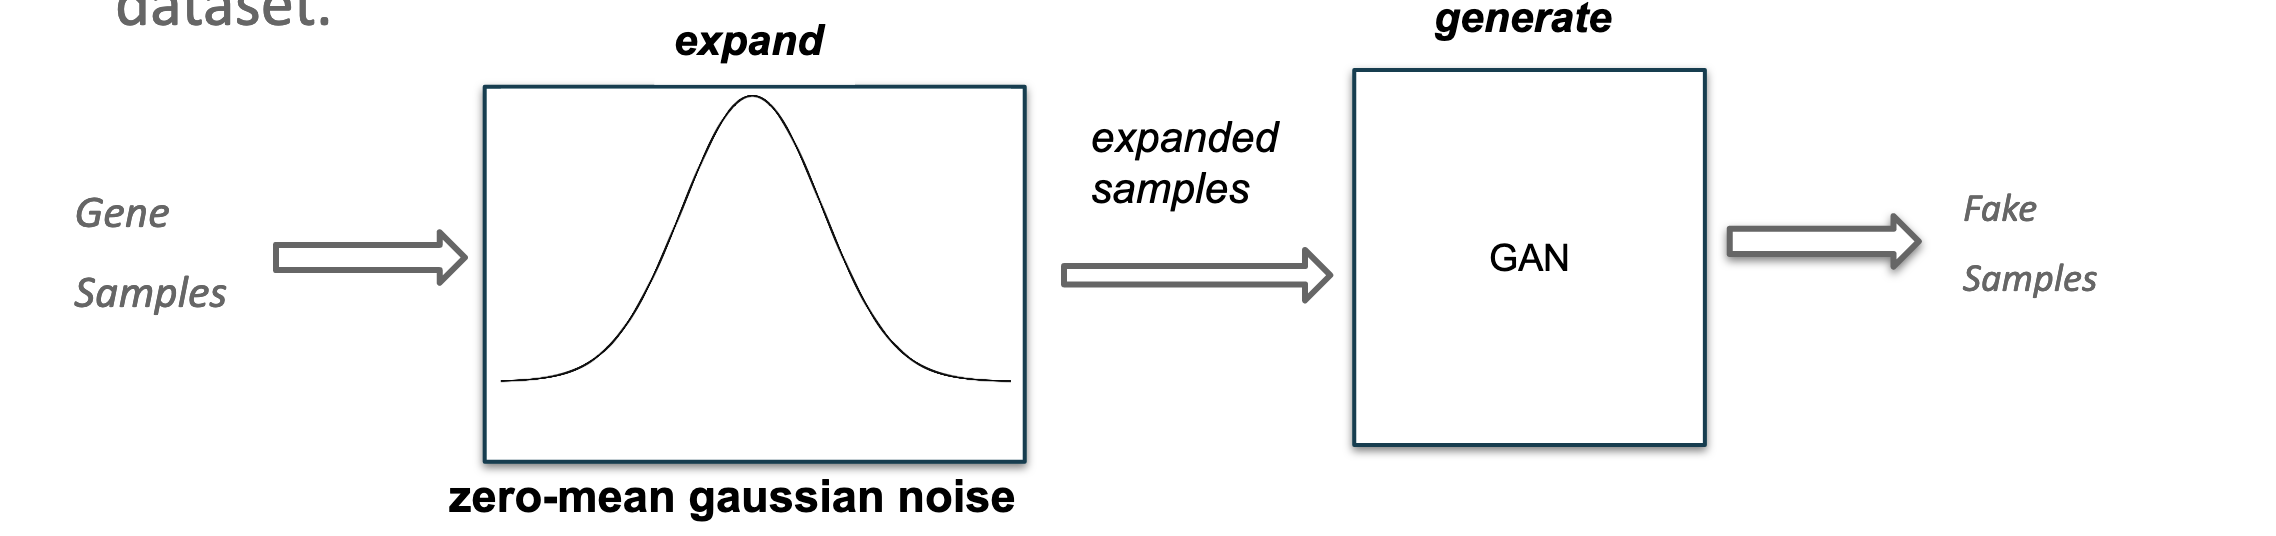

---

The **balanced** version of dataset is the **gender** balanced dataset where we have same proportion of `male` and `female` samples (`gender` being one of many target attributes).

In [9]:
from bps_numerical.preprocessing import DataLoader

In [10]:
CSV_GENE_EXPANDED_BALANCED = "../data/data-v3/expr-balanced-expanded.csv"
CSV_PHENOTYPE_EXPANDED_BALANCED = "../data/data-v3/meta-balanced-expanded.csv"

In [11]:
CSV_GENE_FAKE_BALANCED = "../data/data-v3/expr-balanced-fake.csv"
CSV_PHENOTYPE_FAKE_BALANCED = "../data/data-v3/meta-balanced-expanded.csv"

In [12]:
CSV_GENE_EXPANDED_UNBALANCED = "../data/data-v3/expr-unbalanced-expanded.csv"
CSV_PHENOTYPE_EXPANDED_UNBALANCED = "../data/data-v3/meta-unbalanced-expanded.csv"

In [13]:
CSV_GENE_FAKE_UNBALANCED = "../data/data-v3/expr-unbalanced-fake.csv"
CSV_PHENOTYPE_FAKE_UNBALANCED = "../data/data-v3/meta-unbalanced-expanded.csv"

In [14]:
dataloader_expanded_balanced = DataLoader(
    csv_gene=CSV_GENE_EXPANDED_BALANCED,
    csv_phenotype=CSV_PHENOTYPE_EXPANDED_BALANCED
)

In [15]:
DF_GENES_EXPANDED_BALANCED = dataloader_expanded_balanced.gene_data

2022-12-20 13:29:20.858 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:29:20.859 | INFO     | bps_numerical.preprocessing:standardize_gene_data:37 - Standardizing gene data into proper format.
2022-12-20 13:29:47.883 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6262, 25000)


In [16]:
dataloader_fake_balanced = DataLoader(
    csv_gene=CSV_GENE_FAKE_BALANCED,
    csv_phenotype=CSV_PHENOTYPE_FAKE_BALANCED
)

In [17]:
DF_GENES_FAKE_BALANCED = dataloader_fake_balanced.gene_data

2022-12-20 13:29:47.929 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:29:47.929 | INFO     | bps_numerical.preprocessing:standardize_gene_data:37 - Standardizing gene data into proper format.
2022-12-20 13:30:14.321 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6262, 25000)


In [18]:
dataloader_expanded_unbalanced = DataLoader(
    csv_gene=CSV_GENE_EXPANDED_UNBALANCED,
    csv_phenotype=CSV_PHENOTYPE_EXPANDED_UNBALANCED
)

In [19]:
DF_GENES_EXPANDED_UNBALANCED = dataloader_expanded_unbalanced.gene_data

2022-12-20 13:30:14.351 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:30:14.352 | INFO     | bps_numerical.preprocessing:standardize_gene_data:37 - Standardizing gene data into proper format.
2022-12-20 13:30:46.890 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6832, 25000)


In [20]:
dataloader_fake_unbalanced = DataLoader(
    csv_gene=CSV_GENE_FAKE_UNBALANCED,
    csv_phenotype=CSV_PHENOTYPE_FAKE_UNBALANCED
)

In [21]:
DF_GENES_FAKE_UNBALANCED = dataloader_fake_unbalanced.gene_data

2022-12-20 13:30:46.926 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:30:46.926 | INFO     | bps_numerical.preprocessing:standardize_gene_data:37 - Standardizing gene data into proper format.
2022-12-20 13:31:18.154 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6832, 25000)


In [22]:
cols_genes = dataloader_expanded_balanced.cols_genes_all

In [23]:
# make sure we have same gene features in the both dataset
dataloader_expanded_balanced.cols_genes_all == dataloader_expanded_unbalanced.cols_genes_all

True

In [24]:
len(cols_genes)

25000

In [25]:
DF_MERGED_EXPANDED_BALANCED = dataloader_expanded_balanced.get_merged_data(
    cols_genes=cols_genes
)

2022-12-20 13:31:18.228 | INFO     | bps_numerical.preprocessing:get_merged_data:124 - Combing gene+phenotype data...
2022-12-20 13:31:18.229 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:31:18.230 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6262, 25000)
2022-12-20 13:31:18.231 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:110 - Loading phenotype/attrs only data...
2022-12-20 13:31:18.240 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:116 - Phenotype attrs data loaded | (6262, 13)
2022-12-20 13:31:18.241 | DEBUG    | bps_numerical.preprocessing:get_merged_data:143 - Using 25000 genes!
2022-12-20 13:31:18.691 | INFO     | bps_numerical.preprocessing:merge_gene_phenotype:77 - Merging gene-phenotype dataframes...
2022-12-20 13:31:19.412 | INFO     | bps_numerical.preprocessing:get_merged_data:149 - Merged data | (6262, 25013)


In [26]:
DF_MERGED_FAKE_BALANCED = dataloader_fake_balanced.get_merged_data(
    cols_genes=cols_genes
)

2022-12-20 13:31:19.429 | INFO     | bps_numerical.preprocessing:get_merged_data:124 - Combing gene+phenotype data...
2022-12-20 13:31:19.429 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:31:19.430 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6262, 25000)
2022-12-20 13:31:19.431 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:110 - Loading phenotype/attrs only data...
2022-12-20 13:31:19.440 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:116 - Phenotype attrs data loaded | (6262, 13)
2022-12-20 13:31:19.440 | DEBUG    | bps_numerical.preprocessing:get_merged_data:143 - Using 25000 genes!
2022-12-20 13:31:19.888 | INFO     | bps_numerical.preprocessing:merge_gene_phenotype:77 - Merging gene-phenotype dataframes...
2022-12-20 13:31:20.696 | INFO     | bps_numerical.preprocessing:get_merged_data:149 - Merged data | (6262, 25013)


In [27]:
# dataloader_expanded_unbalanced.df_attrs = None
DF_MERGED_EXPANDED_UNBALANCED = dataloader_expanded_unbalanced.get_merged_data(cols_genes=cols_genes)

2022-12-20 13:31:20.711 | INFO     | bps_numerical.preprocessing:get_merged_data:124 - Combing gene+phenotype data...
2022-12-20 13:31:20.712 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:31:20.713 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6832, 25000)
2022-12-20 13:31:20.713 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:110 - Loading phenotype/attrs only data...
2022-12-20 13:31:20.724 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:116 - Phenotype attrs data loaded | (6832, 13)
2022-12-20 13:31:20.725 | DEBUG    | bps_numerical.preprocessing:get_merged_data:143 - Using 25000 genes!
2022-12-20 13:31:21.089 | INFO     | bps_numerical.preprocessing:merge_gene_phenotype:77 - Merging gene-phenotype dataframes...
2022-12-20 13:31:22.063 | INFO     | bps_numerical.preprocessing:get_merged_data:149 - Merged data | (6832, 25013)


In [28]:
# dataloader_expanded_unbalanced.df_attrs = None
DF_MERGED_FAKE_UNBALANCED = dataloader_fake_unbalanced.get_merged_data(cols_genes=cols_genes)

2022-12-20 13:31:22.078 | INFO     | bps_numerical.preprocessing:get_merged_data:124 - Combing gene+phenotype data...
2022-12-20 13:31:22.079 | INFO     | bps_numerical.preprocessing:gene_data:97 - Loading gene only data...
2022-12-20 13:31:22.080 | INFO     | bps_numerical.preprocessing:gene_data:105 - Gene data loaded | (6832, 25000)
2022-12-20 13:31:22.080 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:110 - Loading phenotype/attrs only data...
2022-12-20 13:31:22.090 | INFO     | bps_numerical.preprocessing:phenotype_attrs_data:116 - Phenotype attrs data loaded | (6832, 13)
2022-12-20 13:31:22.091 | DEBUG    | bps_numerical.preprocessing:get_merged_data:143 - Using 25000 genes!
2022-12-20 13:31:22.391 | INFO     | bps_numerical.preprocessing:merge_gene_phenotype:77 - Merging gene-phenotype dataframes...
2022-12-20 13:31:23.421 | INFO     | bps_numerical.preprocessing:get_merged_data:149 - Merged data | (6832, 25013)


In [29]:
DF_MERGED_EXPANDED_BALANCED.shape, DF_MERGED_EXPANDED_UNBALANCED.shape

((6262, 25013), (6832, 25013))

In [30]:
dataloader_expanded_balanced.df_attrs

,Sample,age,animalreturn,dataset,condition,duration,gender,libPrep,mission,preservation,seqFacility,seqParameters,strain
0,GLDS_245_Mmus_C57_6T_LVR_FLT_LAR_Rep4_F6,32,LAR,GLDS_245,FLT,29,female,ribodepleted,RR6,immediate,GeneLabSPL,PE_149bp_60Mreads,C57BL6T
1,GLDS_168_Mmus_C57_6J_LVR_RR1_GC_noERCC_Rep3_M38,16,ISST,GLDS_168,GC,37,female,ribodepleted,RR1_NASA,carcass,UCDavis,PE_150bp_100Mreads,C57BL6J
2,GLDS_48_Mmus_C57_6J_LVR_GC_I_Rep1_M31,16,ISST,GLDS_48,GC,37,female,polyA,RR1_NASA,immediate,UCDavis,SE_50bp_30Mreads,C57BL6J
3,GLDS_168_Mmus_C57_6J_LVR_RR1_FLT_noERCC_Rep3_M28,16,ISST,GLDS_168,FLT,37,female,ribodepleted,RR1_NASA,carcass,UCDavis,PE_150bp_100Mreads,C57BL6J
4,GLDS_47_Mmus_C57_6T_LVR_GC_Rep3_G5,32,ISST,GLDS_47,GC,21,female,polyA,RR1_CASIS,immediate,UCDavis,SE_50bp_30Mreads,C57BL6T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,GLDS_245_Mmus_C57_6T_LVR_GC_ISS_T_Rep9_G5_1_86...,32,ISST,GLDS_245,GC,54,female,ribodepleted,RR6,carcass,GeneLabSPL,PE_149bp_60Mreads,C57BL6T
6258,GLDS_245_Mmus_C57_6T_LVR_GC_ISS_T_Rep6_G1_1_13...,32,ISST,GLDS_245,GC,54,female,ribodepleted,RR6,carcass,GeneLabSPL,PE_149bp_60Mreads,C57BL6T
6259,GLDS_137_Mmus_BAL_TAL_LVR_GC_Rep2_G2_1_473820,12,ISST,GLDS_137,GC,42,female,ribodepleted,RR3,carcass,UCDavis,PE_150bp_100Mreads,BALBcT
6260,GLDS_242_Mmus_C57_6J_LVR_GC_C2_Rep2_G3_1_830099,10,LAR,GLDS_242,GC,33,male,ribodepleted,RR9,immediate,GeneLabSPL,PE_149bp_60Mreads,C57BL6J


# Gene Ranking Methods

We use tree-based ensemble methods to rank genes (because tree-based models are more interpretable).

We have 2 sets of ranking methods:
- Using the common genes across N models
- MRR-based

---

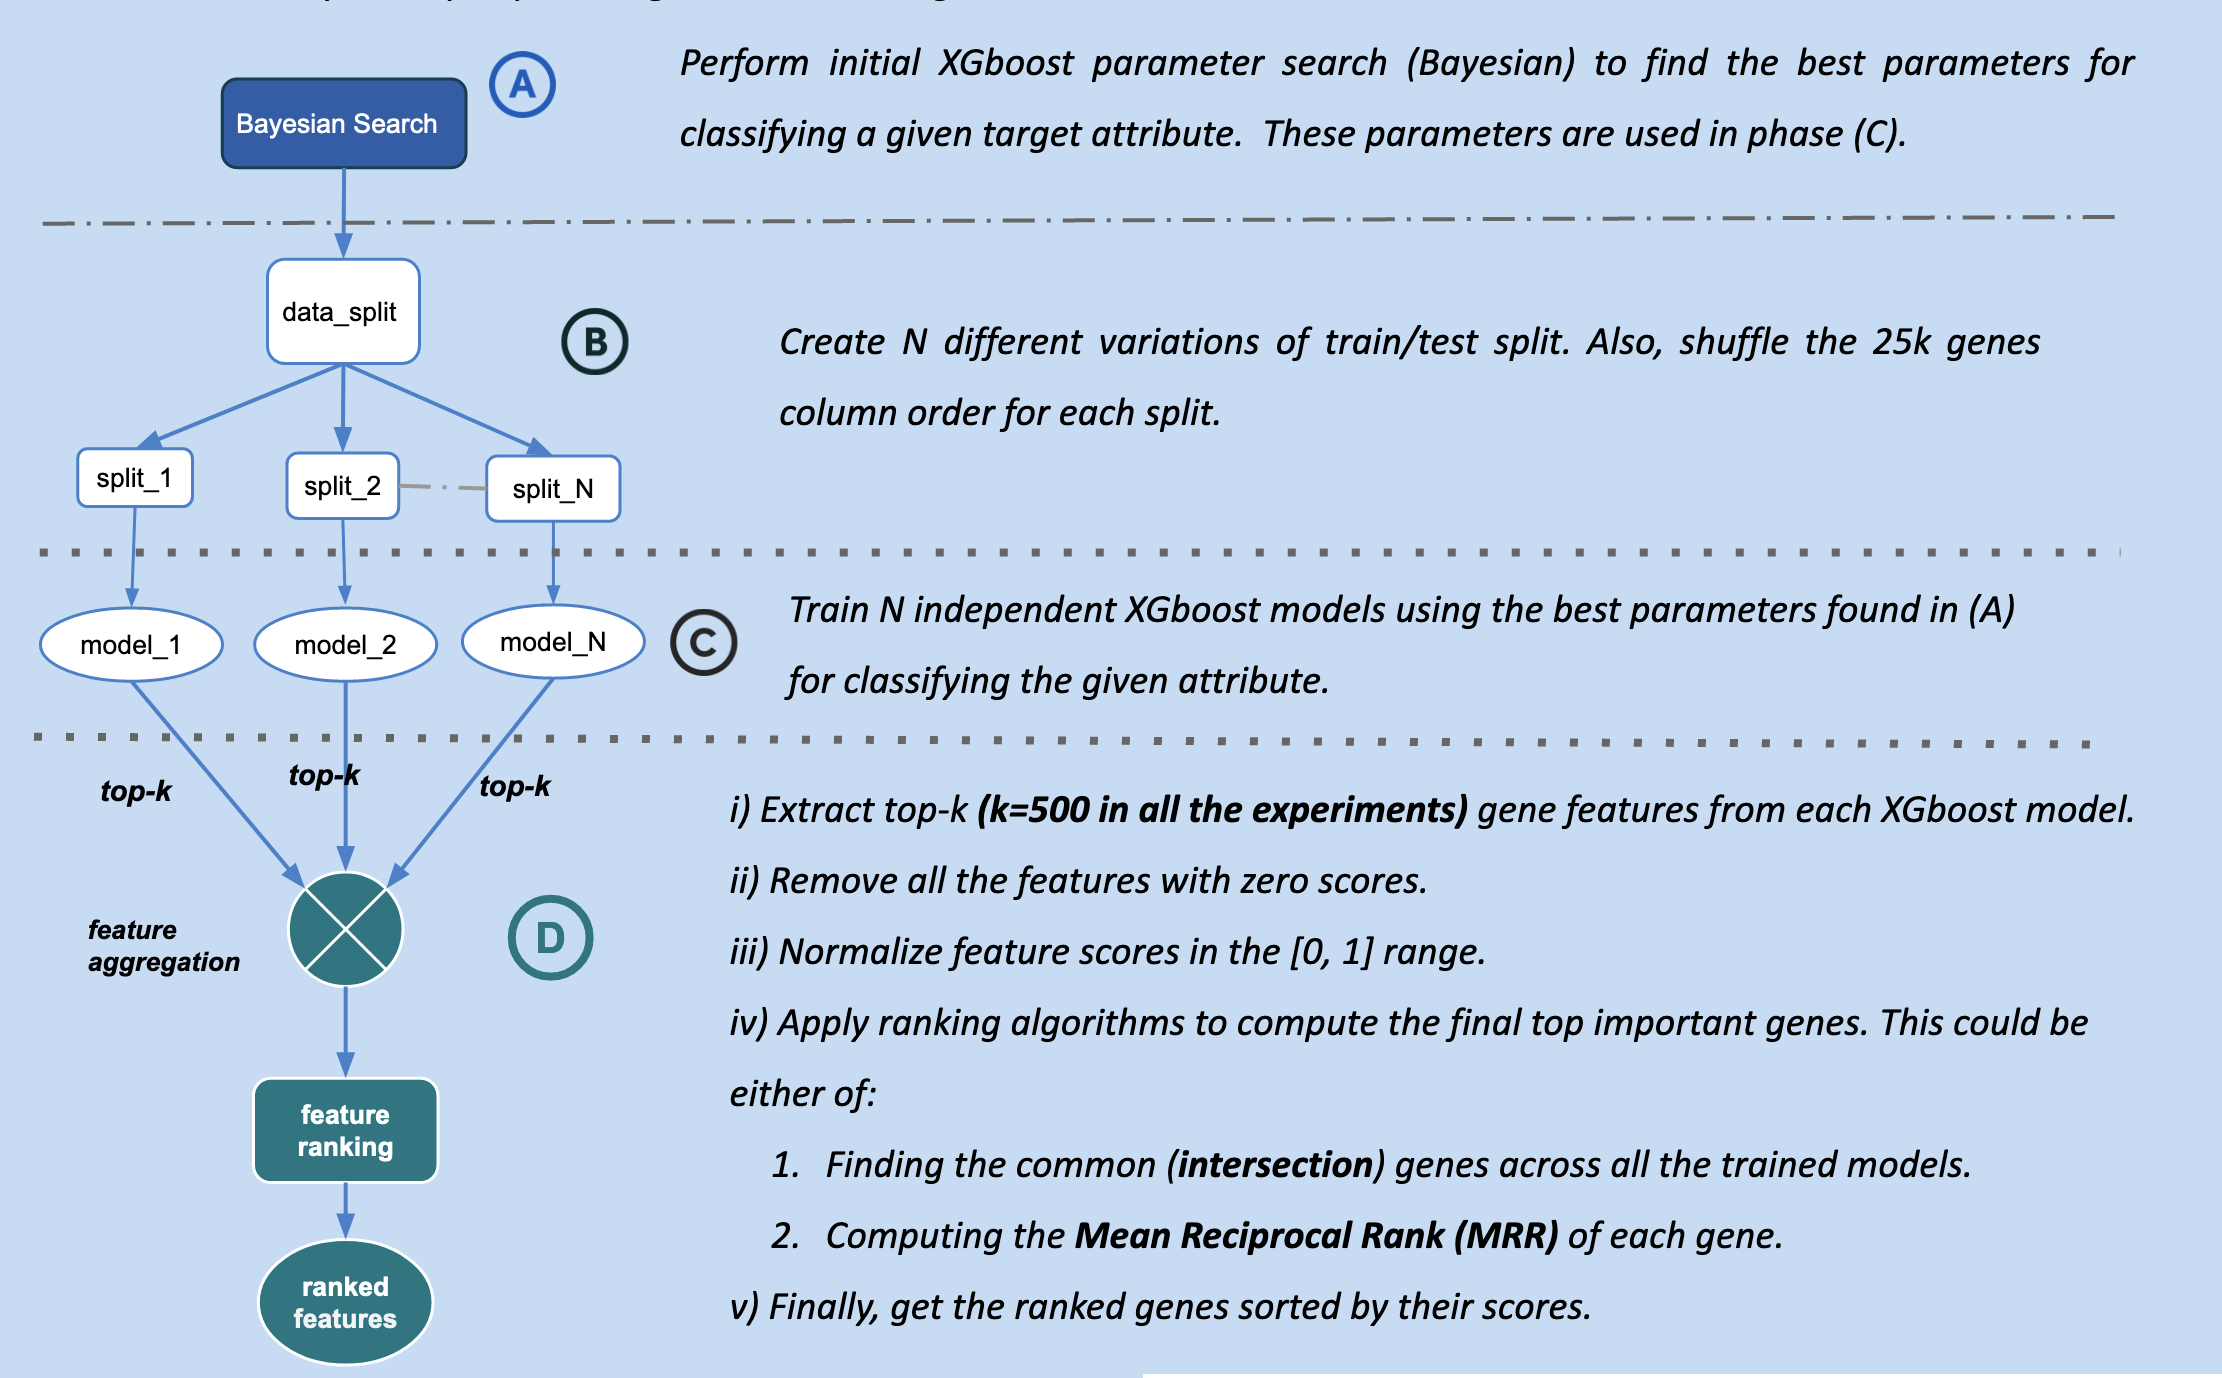

In [31]:
from skopt.callbacks import DeltaYStopper, DeadlineStopper, CheckpointSaver
from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_evaluations

In [32]:
from bps_numerical.classification.feature_scorers import GeneRanker, MeanReciprocalRanker
from bps_numerical.classification.tuner import BayesTuner

In [33]:
phenotype = "gender"
phenotype

'gender'

In [34]:
DF_MERGED_EXPANDED_UNBALANCED[phenotype].value_counts()

female    6283
male       549
Name: gender, dtype: int64

In [35]:
DF_MERGED_EXPANDED_BALANCED[phenotype].value_counts()

female    3193
male      3069
Name: gender, dtype: int64

## setup bayes tuner

### Note 1

If it's a multi-class classification task, use `objective="multi:softmax"`.
If it's a binary classificaiton, use `objective="binary:logistic"`.

### Note 2

We make use of 3 callbacks. The `DeltaYStopper` callback is patience factor for eval score delta.
The `DeadlineStopper` is used for halting the search after a specified time (deadline).

In [37]:
# using tuner from scratch
tuner = BayesTuner(
    columns=cols_genes,
    target_column=phenotype,
    n_iter=12,
    n_jobs=12,
    k_folds=3,
    objective="multi:softmax", # if binary use "binary:logistic", else "multi:softmax"
    callbacks=[
        DeltaYStopper(delta=1e-4),
        DeadlineStopper(12*60*60), #12 hours
        CheckpointSaver(f"tmp/checkpoints/checkpoint-{phenotype}-{time.time}.pkl", compress=9)
    ], # if None -> no callbacks are used, if List -> use that, if empty list -> default callbacks
    debug=True
)
_ = tuner.search_spaces.pop("subsample", None)

## setup GeneRanker

The GeneRanker current iteration uses the bayesian tuner object and searches for the parameter.
At the end its `.get_features(...)` method only gives the common genes across all the trained models.


The `GeneRanker.classifiers` parameter consists of all the models trained which can further be used for downstream analysis.

We can also access the entire training results using `GeneRanker.results` object.

In [38]:
ranker = GeneRanker(
    cols_genes=cols_genes,
    phenotype=phenotype,
    n_runs = 100,
    params_finder=tuner,
    debug=True,
    shuffle_columns=True,
    objective="multi:softmax",
    num_class=5,
)

In [39]:
# can be loaded from saved pickles
ranker = GeneRanker.load("tmp/ranker/gender-25k-tuned.pkl")
# ranker = GeneRanker.load("tmp/ranker/strain-25k-tuned-nov-8.pkl")
# ranker = GeneRanker.load("tmp/ranker/condition-25k-tuned-nov-10.pkl")
# ranker = GeneRanker.load("tmp/ranker/libPrep-25k-tuned-nov-9-no-sumbsample.pkl")

[13:36:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:36:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:36:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences

In [40]:
# Some of the older pickle files had a bug where we didn't have any bayesian tuner object
# rather we had only the saved params dict. So, we had to do this. But you don't have to
# ranker.params_finder = None

## get the ranked features

In [41]:
# common genes across N trained models
features_ranked = ranker.get_features(
    DF_MERGED_EXPANDED_BALANCED,
    test_size=0.1,
    top_k=500,
    ignore_zeros=True,
    normalize=True
)

In [42]:
# ranker.save(f"tmp/ranker/{phenotype}-tuned.pkl")

In [43]:
pprint(features_ranked), len(features_ranked)

[('ENSMUSG00000108431', 0.1982319510882928),
 ('ENSMUSG00000056673', 0.16402160879841587),
 ('ENSMUSG00000066071', 0.1610642346411103),
 ('ENSMUSG00000024694', 0.13291324298517906),
 ('ENSMUSG00000073842', 0.06231306845463536),
 ('ENSMUSG00000075551', 0.061842681674381124),
 ('ENSMUSG00000060181', 0.03412033930556277),
 ('ENSMUSG00000019935', 0.022994820629892273),
 ('ENSMUSG00000110035', 0.021189132608999302),
 ('ENSMUSG00000038092', 0.01999158996721384),
 ('ENSMUSG00000042589', 0.004121809369940603),
 ('ENSMUSG00000041078', 0.0018213709731409189),
 ('ENSMUSG00000074639', 0.0015240500124946265),
 ('ENSMUSG00000045763', 0.0011965325976245821),
 ('ENSMUSG00000087141', 0.0006639011188801191)]


(None, 15)

In [44]:
ranker.params_finder.best_score

0.999680766161213

In [58]:
# access ranker's results
pprint(ranker.results)

[{'classification_report': {'accuracy': 1.0,
                            'female': {'f1-score': 1.0,
                                       'precision': 1.0,
                                       'recall': 1.0,
                                       'support': 320},
                            'macro avg': {'f1-score': 1.0,
                                          'precision': 1.0,
                                          'recall': 1.0,
                                          'support': 627},
                            'male': {'f1-score': 1.0,
                                     'precision': 1.0,
                                     'recall': 1.0,
                                     'support': 307},
                            'weighted avg': {'f1-score': 1.0,
                                             'precision': 1.0,
                                             'recall': 1.0,
                                             'support': 627}},
  'confusion_matrix': array([[320,

## compute MRR-based feature set

Once we have the models trained in the `GeneRanker`, we can use those models to further compute MRRs.
> Note: In future iteration, we could have single ranking component and could provide a way to switch between
different ranking algorithms (common, MRR, et al)

In [45]:
features_mrr = MeanReciprocalRanker(
    *[
        _clf
        for _clf, _result in zip(ranker.classifiers, ranker.results)
        if _result["train_score"]==1.0 and _result["test_score"] == 1.0 # we could filter models based on their train/test score
    ],
    score_cutoff=0.1,
    rank_cutoff=0.1,
    debug=True,
).get_features()

2022-12-20 13:37:00.207 | DEBUG    | bps_numerical.classification.feature_scorers:get_features:709 - 81 in use.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33913.26it/s]


In [46]:
pprint(features_mrr), len(features_mrr)

[('ENSMUSG00000108431', 1.0),
 ('ENSMUSG00000056673', 0.8205128205128203),
 ('ENSMUSG00000066071', 0.728205128205128),
 ('ENSMUSG00000024694', 0.7179487179487177),
 ('ENSMUSG00000040583', 0.5025641025641024),
 ('ENSMUSG00000073842', 0.3384615384615385),
 ('ENSMUSG00000037263', 0.3025641025641025),
 ('ENSMUSG00000075551', 0.2871794871794871),
 ('ENSMUSG00000070811', 0.28717948717948705),
 ('ENSMUSG00000074254', 0.2256410256410256),
 ('ENSMUSG00000079494', 0.19487179487179482),
 ('ENSMUSG00000060181', 0.17435897435897432),
 ('ENSMUSG00000024421', 0.16410256410256405),
 ('ENSMUSG00000078672', 0.1333333333333333),
 ('ENSMUSG00000078597', 0.12307692307692306),
 ('ENSMUSG00000078798', 0.11794871794871793),
 ('ENSMUSG00000108589', 0.11794871794871793)]


(None, 17)

# Misc

## plot 

In [48]:
_ = plot_feature_scores(features_ranked)

In [49]:
_ = plot_feature_scores(features_mrr)

## box plot train/test scores

<AxesSubplot:>

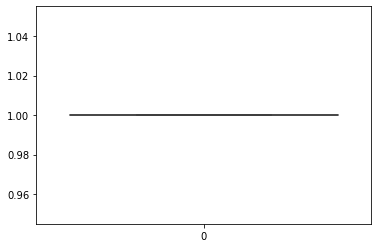

In [53]:
_x, _y = zip(*list(map(lambda x: (x["train_score"], x["test_score"]), ranker.results)))
sns.boxplot(_x)

<AxesSubplot:>

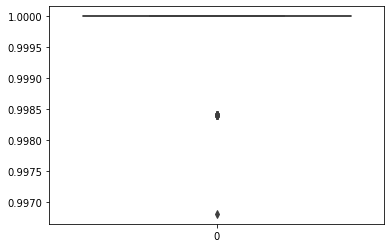

In [54]:
_x, _y = zip(*list(map(lambda x: (x["train_score"], x["test_score"]), ranker.results)))
sns.boxplot(_y)

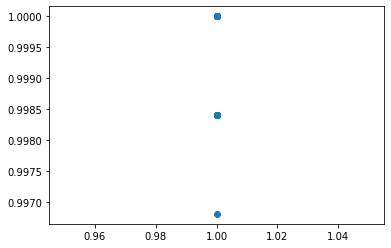

In [56]:
plt.scatter(_x, _y)

## PhenotypeFeatureScorer

Internally, `GeneRanker` uses `PhenotypeFeatureScorer` component to compute the intersection using all the N models.

However, we are free to provide any selected models to it.

In [60]:
from bps_numerical.classification.feature_scorers import PhenotypeFeatureScorer, ShapBasedPhenotypeFeatureScorer

In [65]:
pprint(PhenotypeFeatureScorer(*ranker.classifiers[:10]).get_features(top_k=500, normalize=True, ignore_zeros=True))

[('ENSMUSG00000024694', 0.32953713221290853),
 ('ENSMUSG00000037263', 0.2446524872174848),
 ('ENSMUSG00000066071', 0.12753009338071025),
 ('ENSMUSG00000108431', 0.11053173301963),
 ('ENSMUSG00000108589', 0.1096641171286791),
 ('ENSMUSG00000078597', 0.10047794562659859),
 ('ENSMUSG00000070811', 0.10000506596175499),
 ('ENSMUSG00000075551', 0.08810628748702669),
 ('ENSMUSG00000019935', 0.07881896792678163),
 ('ENSMUSG00000079494', 0.07304928980264976),
 ('ENSMUSG00000022181', 0.04027949828639947),
 ('ENSMUSG00000038092', 0.0360027882384145),
 ('ENSMUSG00000056673', 0.031737572803552896),
 ('ENSMUSG00000060181', 0.016160783617442574),
 ('ENSMUSG00000110035', 0.013712718971487448),
 ('ENSMUSG00000073842', 0.010879377119150036),
 ('ENSMUSG00000074639', 0.008587223349422857),
 ('ENSMUSG00000042589', 0.008548269799996433),
 ('ENSMUSG00000028890', 0.006622043673058897),
 ('ENSMUSG00000020023', 0.004980723094013229),
 ('ENSMUSG00000040583', 0.004863924477461978),
 ('ENSMUSG00000037669', 0.00465

In [64]:
# get common genes across first 10 models
_ = plot_feature_scores(
    PhenotypeFeatureScorer(*ranker.classifiers[:10]).get_features(top_k=500, normalize=True, ignore_zeros=True)
)

## Shap-based common features

Similar to `PhenotypeFeatureScorer`, we can use `ShapBasedFeatureScorer` to compute important common genes.
Unlike `PhenotypeFeatureScorer`, Shap-based scorer requires input data to compute the feature attribution
across N models and aggregate.

> Note: It's slower because we are doing shap-based attribution N times.

In [66]:
from bps_numerical.classification.feature_scorers import ShapBasedPhenotypeFeatureScorer

In [67]:
# using first 10 trained classifers
pprint(ShapBasedPhenotypeFeatureScorer(*ranker.classifiers[:10]).get_features(DF_MERGED_FAKE_BALANCED, top_k=500, ignore_zeros=True, normalize=True))

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishpara

[('ENSMUSG00000024694', 0.5897691249847412),
 ('ENSMUSG00000019935', 0.559321117401123),
 ('ENSMUSG00000066071', 0.524434757232666),
 ('ENSMUSG00000060181', 0.353072452545166),
 ('ENSMUSG00000056673', 0.21086180210113525),
 ('ENSMUSG00000037263', 0.20425987243652344),
 ('ENSMUSG00000108589', 0.19210126399993896),
 ('ENSMUSG00000108431', 0.18982508182525634),
 ('ENSMUSG00000079494', 0.18557004928588866),
 ('ENSMUSG00000110035', 0.18366745710372925),
 ('ENSMUSG00000040583', 0.1808495044708252),
 ('ENSMUSG00000074639', 0.1798102855682373),
 ('ENSMUSG00000078597', 0.16106148958206176),
 ('ENSMUSG00000038092', 0.1406649947166443),
 ('ENSMUSG00000037669', 0.13939510583877562),
 ('ENSMUSG00000041078', 0.1280243992805481),
 ('ENSMUSG00000073842', 0.12443842887878417),
 ('ENSMUSG00000045763', 0.12248829603195191),
 ('ENSMUSG00000075551', 0.11702853441238403),
 ('ENSMUSG00000070811', 0.10845099687576294),
 ('ENSMUSG00000087141', 0.09887561798095704),
 ('ENSMUSG00000028890', 0.07546245455741882),

In [68]:
_ = plot_feature_scores(ShapBasedPhenotypeFeatureScorer(*ranker.classifiers[:10]).get_features(DF_MERGED_FAKE_BALANCED, top_k=500, ignore_zeros=True, normalize=True))

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/Users/nishpara

# Validation and Evaluation

Validate the ranked features by training a new model with selected feature sets

In [69]:
from bps_numerical.classification import SinglePhenotypeClassifier, MultiPhenotypeIsolatedClassifier

In [70]:
from sklearn.metrics import confusion_matrix, classification_report

In [71]:
def eval_ranker_single(clf: SinglePhenotypeClassifier, data: pd.DataFrame, cols_genes: List[str], labels):
    __model = clf.model
    print(f"Value counts for phenotype={clf.phenotype}, ", data[clf.phenotype].value_counts())
    cols_genes = list(cols_genes)
    x_test = data[cols_genes]
    y_test = clf.target_encoder.transform(data[[clf.phenotype]])
    print(y_test.shape)
    
    score = round(__model.score(x_test, y_test), 3)*100
    print(f"score = {score}%")
    
    y_preds = __model.predict(x_test)
    y_preds = np.asarray(y_preds).argmax(axis=1) if y_preds.ndim > 1 else y_preds
    
    y_test = np.asarray(y_test).argmax(axis=1) if y_test.ndim > 1 else y_test

    cm = confusion_matrix(y_test, y_preds)
    cr = classification_report(
            y_test,
            y_preds,
            target_names=labels,
            output_dict=True,
        )
    return dict(confusion_matrix = cm, classification_report = cr, score=score)

In [72]:
xgboost_params = copy.deepcopy(ranker.xgboost_params)
xgboost_params.pop("colsample_bytree")
xgboost_params.pop("subsample", None)

xgboost_params

{'gamma': 1.033938102132757e-08,
 'learning_rate': 0.8044538136113831,
 'max_delta_step': 20,
 'max_depth': 28,
 'min_child_weight': 0,
 'n_estimators': 245,
 'reg_alpha': 0.05951616099811858,
 'reg_lambda': 3.3784779506328877,
 'scale_pos_weight': 1.8996862931477567}

In [74]:
clf_val = SinglePhenotypeClassifier(
    cols_genes = list(map(lambda f: f[0], features_ranked)),
    phenotype = phenotype,
    **xgboost_params
)

In [75]:
results_clf = clf_val.train(DF_MERGED_FAKE_BALANCED)

2022-12-20 13:53:40.998 | DEBUG    | bps_numerical.classification.classifiers:fit:92 - Training took 0.7558529376983643 seconds.


In [76]:
pprint(results_clf)

{'classification_report': {'accuracy': 1.0,
                           'female': {'f1-score': 1.0,
                                      'precision': 1.0,
                                      'recall': 1.0,
                                      'support': 639},
                           'macro avg': {'f1-score': 1.0,
                                         'precision': 1.0,
                                         'recall': 1.0,
                                         'support': 1253},
                           'male': {'f1-score': 1.0,
                                    'precision': 1.0,
                                    'recall': 1.0,
                                    'support': 614},
                           'weighted avg': {'f1-score': 1.0,
                                            'precision': 1.0,
                                            'recall': 1.0,
                                            'support': 1253}},
 'confusion_matrix': array([[639,   0],
       [ 

In [77]:
eval_ranker_single(clf_val, DF_MERGED_EXPANDED_BALANCED, clf_val.cols_genes, results_clf.get("labels"))

Value counts for phenotype=gender,  female    3193
male      3069
Name: gender, dtype: int64
(6262,)
score = 99.8%


/Users/nishparadox/dev/uah/nasa-impact/bps-numerical/venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'confusion_matrix': array([[3184,    9],
        [   2, 3067]]),
 'classification_report': {'female': {'precision': 0.9993722536095417,
   'recall': 0.9971813341684935,
   'f1-score': 0.9982755917855464,
   'support': 3193},
  'male': {'precision': 0.997074122236671,
   'recall': 0.999348321928967,
   'f1-score': 0.9982099267697315,
   'support': 3069},
  'accuracy': 0.9982433727243692,
  'macro avg': {'precision': 0.9982231879231064,
   'recall': 0.9982648280487303,
   'f1-score': 0.998242759277639,
   'support': 6262},
  'weighted avg': {'precision': 0.9982459416990753,
   'recall': 0.9982433727243692,
   'f1-score': 0.9982434094263104,
   'support': 6262}},
 'score': 99.8}

# PCA

We do the PCA projection analysis here.

In [78]:
from sklearn.decomposition import PCA

features_ranked 0.945
features_mrr 0.972
features_25k 0.446


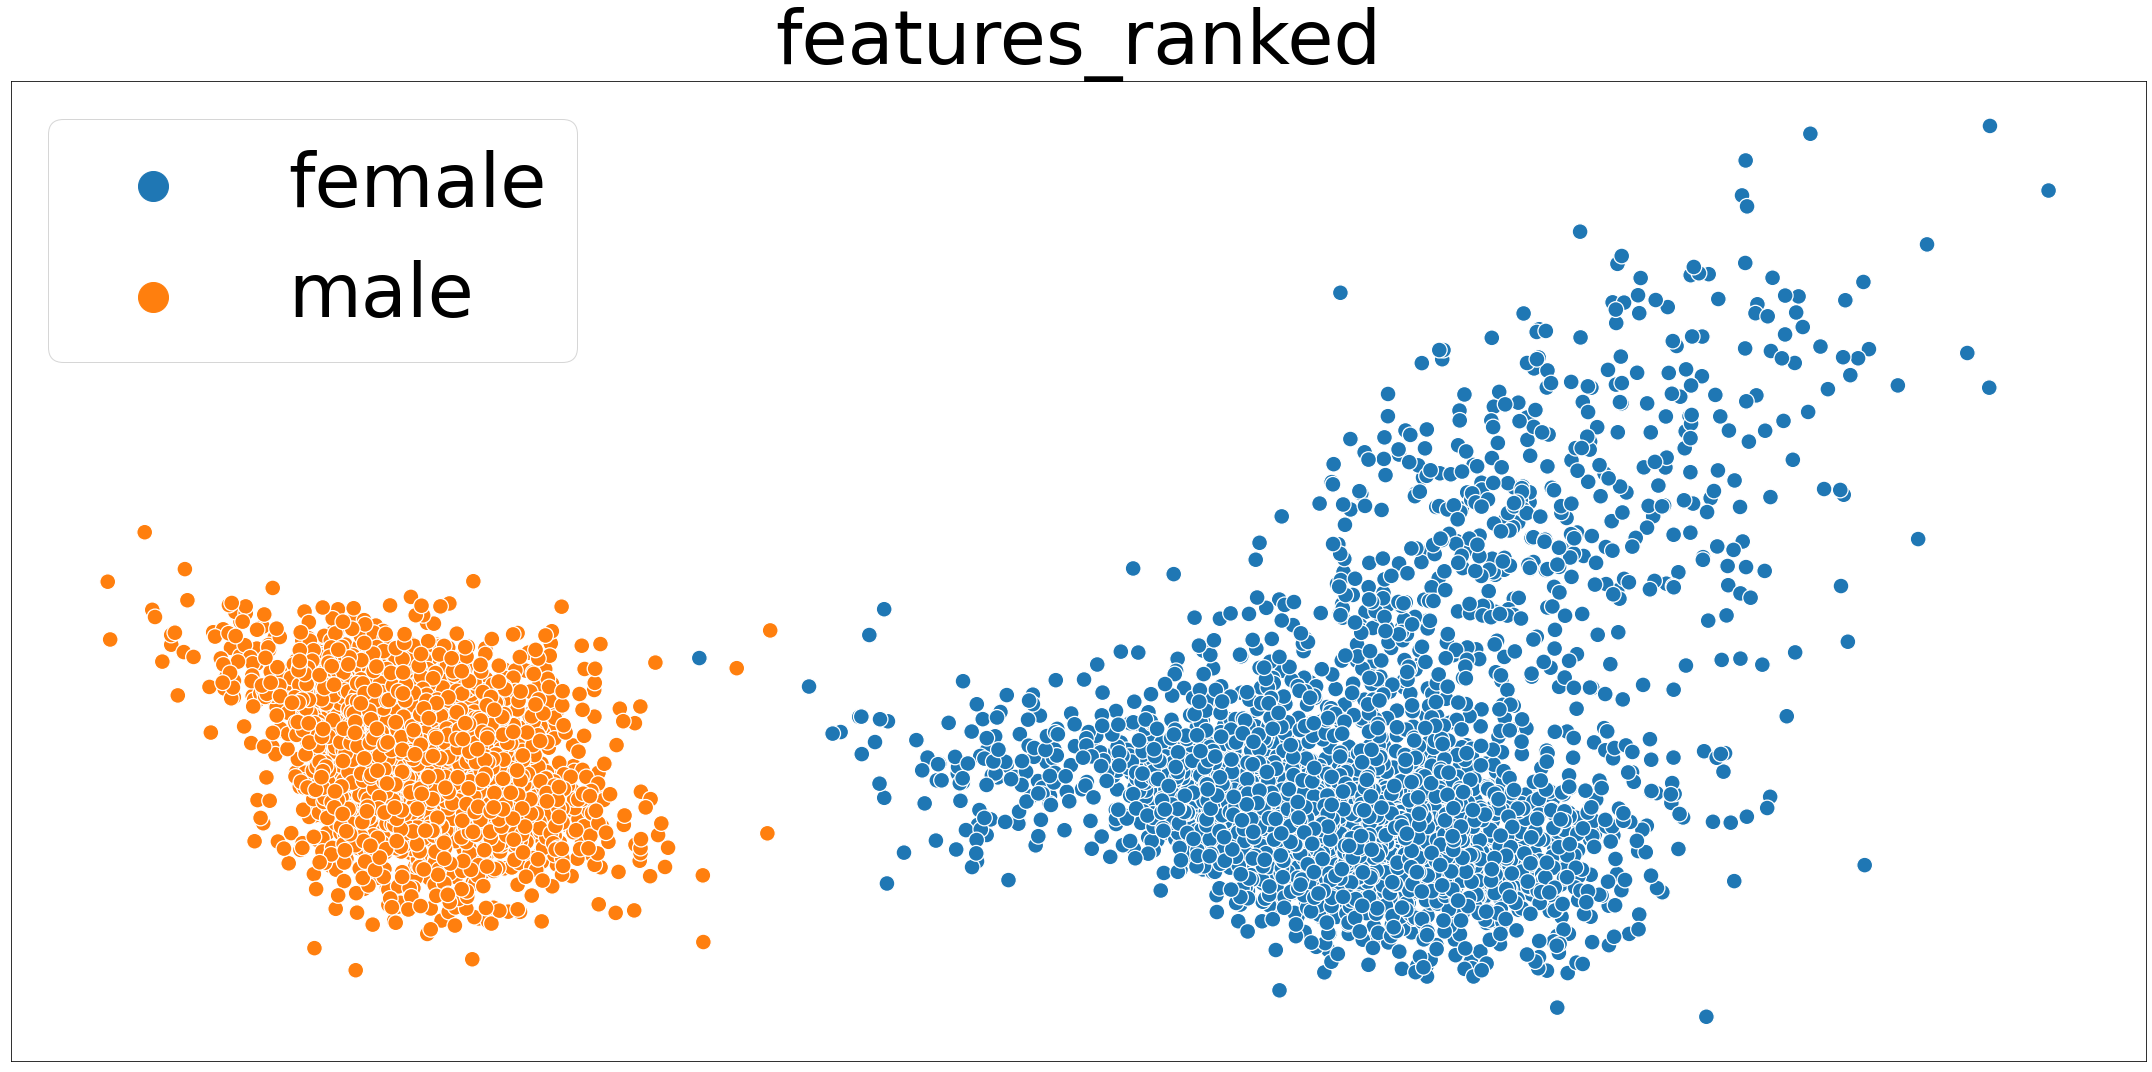

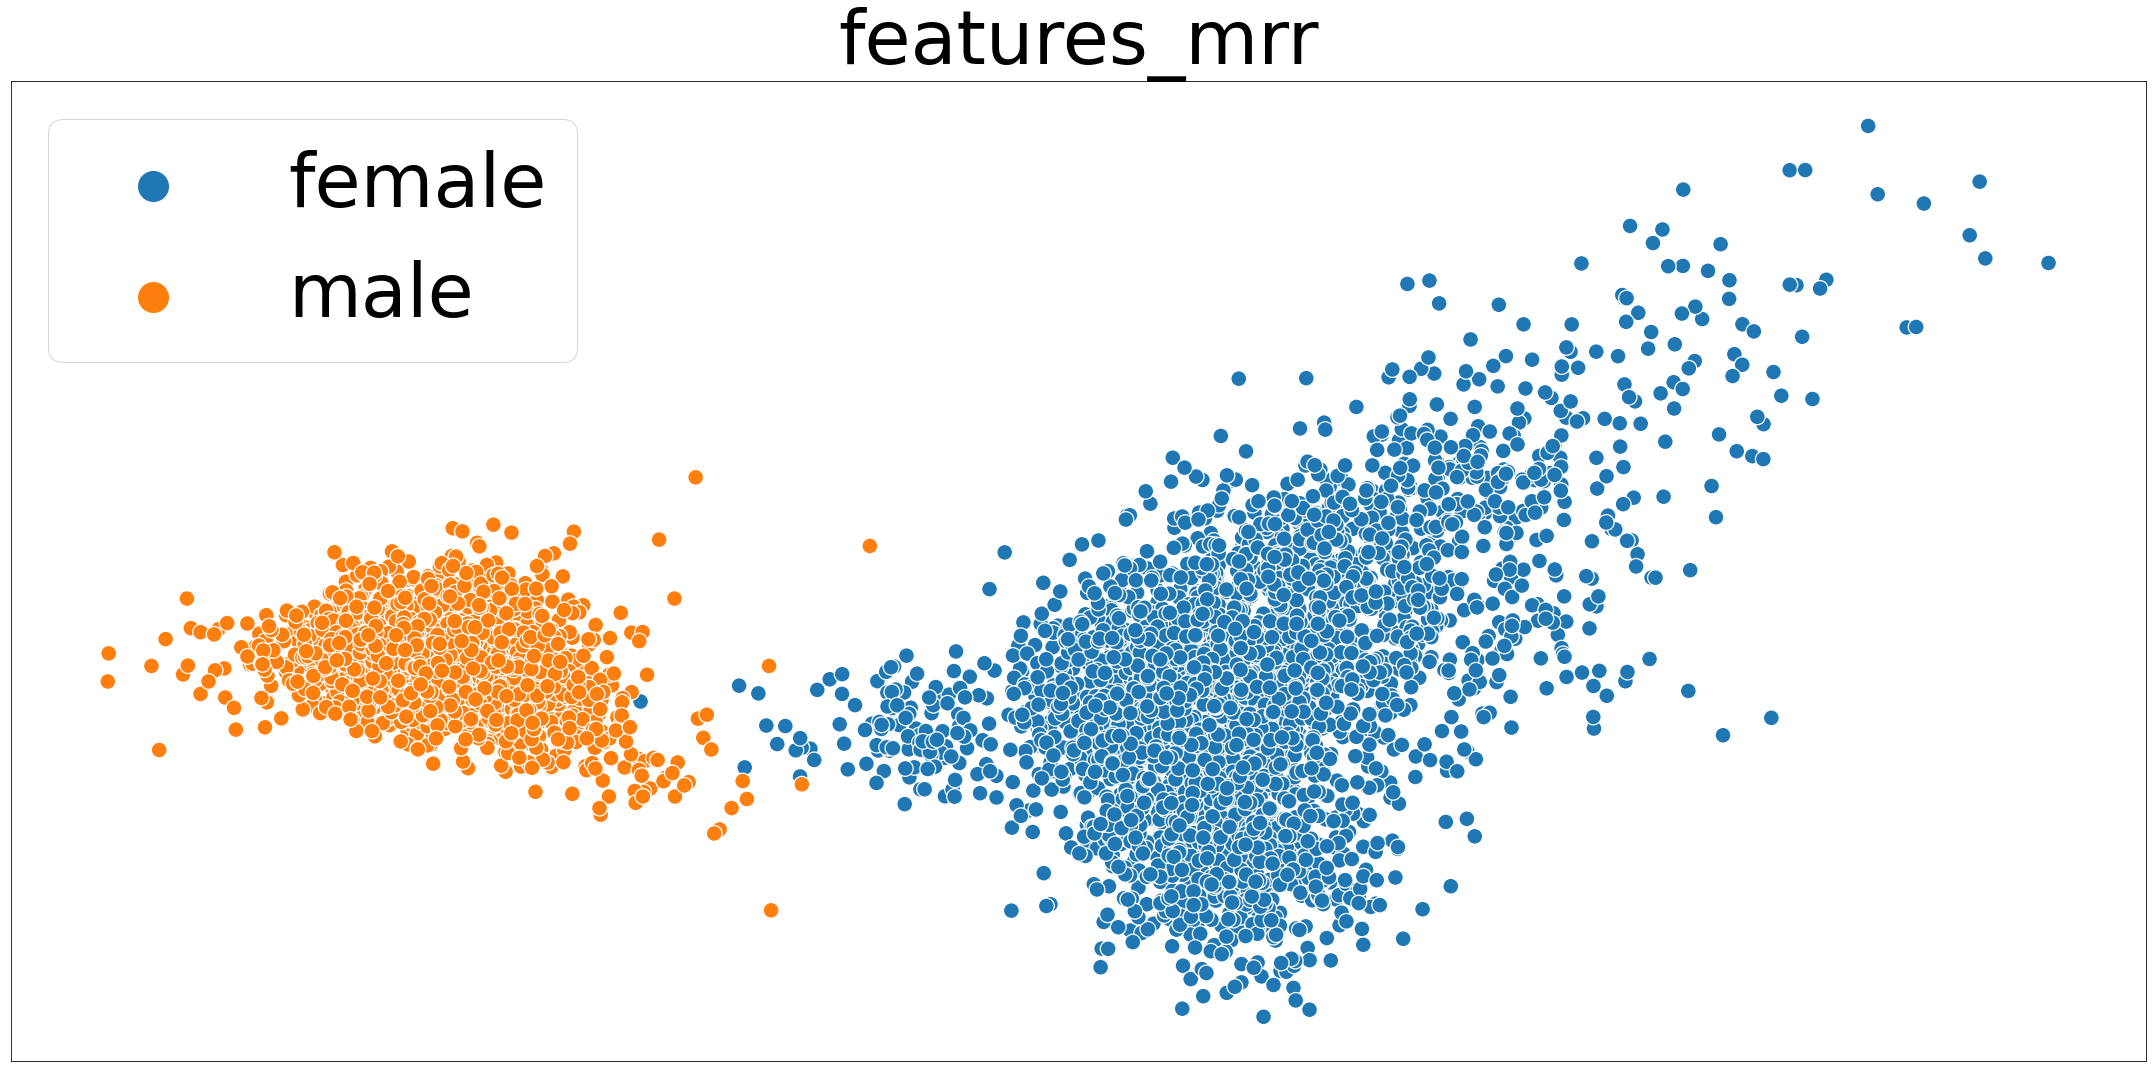

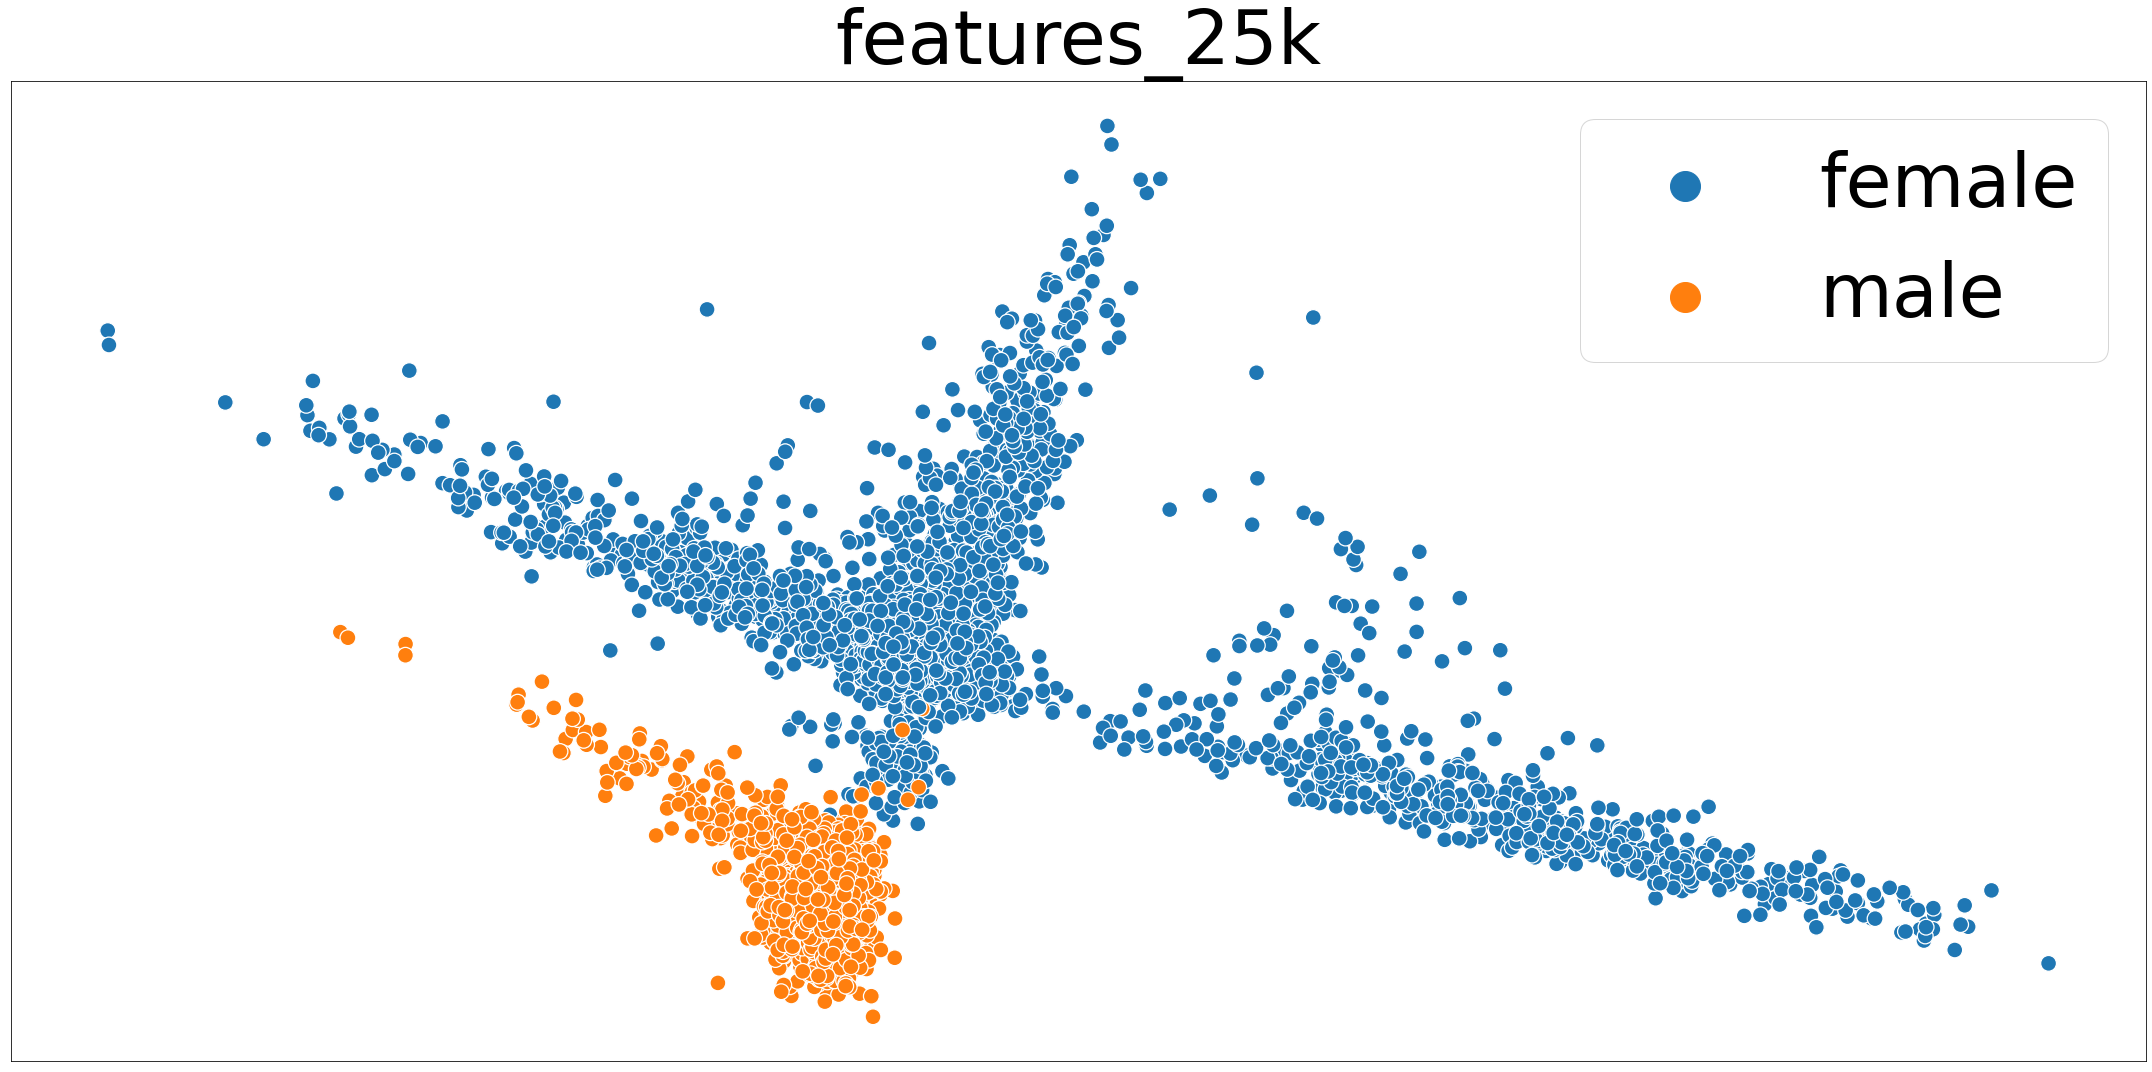

In [79]:
feature_sets = [
    ("features_ranked", features_ranked),
    ("features_mrr", features_mrr),
    ("features_25k", list(zip(cols_genes, [1.0 for i in range(len(dataloader_expanded_balanced.cols_genes_all))])))
]
fontsize=75
for ftype, _features in feature_sets:
    plt.figure(figsize=(30, 15))
    genes_to_use, _ = zip(*_features)
    genes_to_use = list(genes_to_use)
    if len(genes_to_use) < 2:
        continue
    pca = PCA(n_components=2)
    X = pca.fit_transform(DF_MERGED_EXPANDED_BALANCED[genes_to_use])
    _var = round(pca.explained_variance_ratio_.sum(), 3)
    print(ftype, _var)
    ax = sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=DF_MERGED_EXPANDED_BALANCED[phenotype],
        s=250,
    )
    legend = ax.legend()

    legend.markerscale = 500
    ax.set_xticks([])
    ax.set_yticks([])
    plt.legend(markerscale=5, fontsize=fontsize)
#     plt.setp(legend.get_texts(), fontsize=fontsize-10) 
#     plt.ylabel("PC 1", fontsize=fontsize, labelpad=5)
#     plt.xlabel("PC 2", fontsize=fontsize, labelpad=5)
    
#     plt.text(0.5, 0.9, f"explained_variance_ratio={_var}", horizontalalignment='center', verticalalignment='top', transform=ax.transAxes, fontsize=fontsize)
#     plt.title(f"PCA plot for {phenotype} {ftype} genes on balanced_expanded", fontsize=fontsize)
    plt.title(f"{ftype}", fontsize=fontsize)
    plt.tight_layout()
#     plt.savefig(f"tmp/slides-deck/{phenotype}/PCA-{ftype}.png")

# Misc: Booster viz

In [ ]:
import eli5

In [ ]:
_model = copy.deepcopy(ranker.classifiers[0].model)
booster = _model.get_booster()
original_feature_names = booster.feature_names
# booster.feature_names = vec.get_feature_names()
print(booster.get_dump()[0])
# recover original feature names
# booster.feature_names = original_feature_names

In [ ]:
print(booster.get_dump()[2])

In [ ]:
PhenotypeFeatureScorer(ranker.classifiers[0]).get_features(top_k=500)

In [ ]:
eli5.show_weights(_model, importance_type="gain")

In [ ]:
eli5.show_weights(_model, importance_type="weight")

In [ ]:
eli5.show_weights(_model, importance_type="cover")

In [ ]:
eli5.show_weights(_model, importance_type="gain")

In [ ]:
eli5.show_weights(_model, importance_type="total_gain")

In [ ]:
eli5.show_weights(_model, importance_type="total_cover")